# Collaboration and Competition

---

This notebook is based on the notebook of the coding exercice [DDPG-pendulum](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum) of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


Here, we will train a MADDPG multi-agent for **Tennis** environment.


### 1. Import the Necessary Packages

We begin by importing the necessary packages.

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg_agent import MADDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
# Initialise the agents
agents=MADDPG(state_size,action_size,num_agents,random_seed=1,path="Tennis_checkpoint")

### 3. Train the Agents with MADDPG

Run the code cell below to train the agents from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [6]:
def trainer(n_episodes=4000, max_t=1000):
    np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf*np.ones(num_agents)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]                # reset the environment    
        states = list(env_info.vector_observations)                  # get the current state
        agents.reset()
        agents_score = np.zeros(num_agents)
        for t in range(max_t):
           
            actions = agents.act(states,True)
            env_info = env.step(np.vstack(actions))[brain_name]      # send all actions to tne environment
            next_states = list(env_info.vector_observations)                             # get next state (for each agent)
            rewards = list(env_info.rewards)                                             # get reward (for each agent)
            dones = list(env_info.local_done)                                            # see if episode finished
            
            agents.step(states, actions, rewards, next_states, dones, t)
                
            states = next_states.copy()
            agents_score += rewards                       # update the score (for each agent)
            if np.any(dones):
                break 
                
        scores_deque.append(agents_score)
        scores.append(agents_score)
        mean=np.mean(scores_deque,axis=0)
        
        
        print('\rEpisode {}\tAverage Scores: {} \tScores: {}'.format(i_episode, mean , agents_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Scores: {}'.format(i_episode, mean))
        
        idx=np.where(mean>=max_score)[0]
        max_score[idx]=mean[idx]
        agents.save(idx)
        
        if (max_score>.5).all():
            print("\n Solved in",i_episode,"episode")
            break
            
    return np.array(scores)

In [7]:
scores=trainer()

Episode 100	Average Scores: [-0.0016 -0.0045] 	Scores: [-0.0100  0.0000]
Episode 200	Average Scores: [-0.0048 -0.0052] 	Scores: [ 0.0000 -0.0100]
Episode 300	Average Scores: [-0.0048 -0.0052] 	Scores: [-0.0100  0.0000]
Episode 400	Average Scores: [-0.0051 -0.0049] 	Scores: [ 0.0000 -0.0100]
Episode 500	Average Scores: [-0.0035  0.0015] 	Scores: [-0.0100  0.0000]
Episode 600	Average Scores: [-0.0039 -0.0051] 	Scores: [ 0.0000 -0.0100]
Episode 700	Average Scores: [-0.0047 -0.0053] 	Scores: [ 0.0000 -0.0100]
Episode 800	Average Scores: [-0.0042 -0.0048] 	Scores: [ 0.1000 -0.0100]
Episode 900	Average Scores: [ 0.0060  0.0000] 	Scores: [ 0.0000 -0.0100]
Episode 1000	Average Scores: [ 0.0058  0.0012] 	Scores: [-0.0100  0.0000]
Episode 1100	Average Scores: [ 0.0190  0.0160] 	Scores: [ 0.0000  0.0900]
Episode 1200	Average Scores: [ 0.0334  0.0236] 	Scores: [ 0.0000 -0.0100]
Episode 1300	Average Scores: [ 0.0362  0.0328] 	Scores: [ 0.1000 -0.0100]
Episode 1400	Average Scores: [ 0.0432  0.0378] 

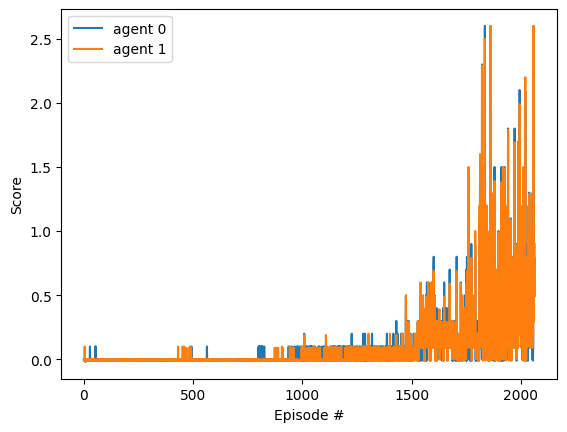

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
itr=np.arange(1, len(scores)+1)
for i in range(num_agents):
    plt.plot(itr, scores[:,i],label="agent %i" %i)
    
ax.legend()    
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch the Smart Agent!

In the next code cell, we will load the trained weights and test the model.

In [11]:
agents.load()
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agents.act(states,False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score from episode {}: {}'.format(i, scores))

Score from episode 1: [ 2.6000  2.7000]
Score from episode 2: [ 0.2000  0.1900]
Score from episode 3: [ 2.6000  2.6000]
Score from episode 4: [ 2.7000  2.6000]
Score from episode 5: [ 2.6000  2.7000]


When finished, you can close the environment.

In [12]:
env.close()